# Planet Amazon Image Classification - Transfer Learning


This notebooks utilizes the VGG16 deep layer convolutional model to made predictions on the satellite images. We also examine the results, model performance and explore options to improve upon the classification.

## Importing the Data

In [5]:
#import modules
import numpy as np 
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
#import pickle
from IPython.display import display
from skimage import io
%matplotlib inline

# Define files and directories
#os.chdir('C:/Users/isado/Documents/SpringBoard/Capstone2/')
         
# Create DataFrame with training labels
train_labels = pd.read_csv('../train_classes.csv')
#train_labels = pd.read_csv('/floyd/input/amazon_train_classes/train_classes.csv')

In [6]:
#Extracting unique labels
labels = []
for tags in train_labels.tags.values:
    label = tags.split(' ')
    for subitem in label:
        if subitem not in labels:
            labels.append(subitem)

#One Hot encoding labels
for label in labels:
    train_labels[label] = train_labels['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
train_labels.index = train_labels.image_name

In [9]:
from skimage.transform import resize
from skimage.color import rgb2gray

#For the pretrained NeuralNet the input images must be prepared in the same way as the ImageNet training data was prepared. 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_image(file_name, fig_type='jpg', size=256, n_channels=3):
    
    """Loads the requested image resized and preprocesses for VGG16 model"""
    img_path = ('../train-{}/{}.{}').format(fig_type,file_name,fig_type)
    #img_path = ('/floyd/input/amazon_images/{}.{}').format(file_name,fig_type)
    img = image.load_img(img_path, target_size=(size, size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    return (img)

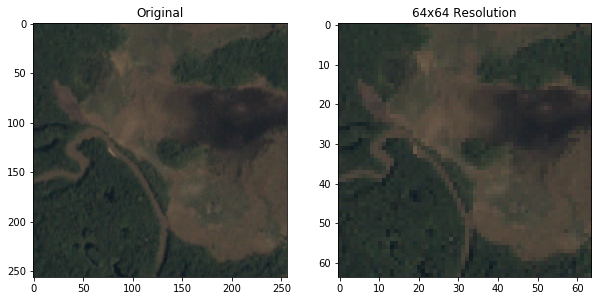

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

ax = axes.ravel()
ax[0].imshow(load_image('train_10'))
ax[0].set_title("Original")
ax[1].imshow(load_image('train_10', size=64))
ax[1].set_title("64x64 Resolution");

In [7]:
#Create a lookup dictionary containing the labels for each image sample

labels_dict={}
labels_array = np.array(train_labels.iloc[:,-17:])

for i, sample in enumerate(train_labels.index):
    labels_dict[sample] = labels_array[i]

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [9]:
#RAM size limitation makes it so we have to process our data in mini-batches

from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

#adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=64, dim=(64,64), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = list(np.empty((self.batch_size)))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_image(ID, size=self.dim[0], n_channels=self.n_channels)

            # Store class
            y[i] = self.labels[ID]

        return X, np.array(y)

In [10]:
#Write function to get f1-score metric for Keras
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Transfer Learning
 - Batch size = 512
 - Training set size = 20000
 - Validation set size = 7000
 - Image Res: 64x64 RGB
 - Early stopping: validation loss with patience of 5
 - Metric: F1 score

In [11]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, BatchNormalization
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define a callback to monitor validation accuracy
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Parameters
params = {'dim': (64,64),
          'batch_size': 512, #batch size adjusted to speed up training
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(train_labels.index[0:20000], labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[20000:27000], labels_dict, **params)

##Define the model

transfer_model = VGG16( include_top=False,
                        weights="imagenet",
                        input_shape=(64, 64, 3))

model = Sequential()

# Batchnorm input
model.add(BatchNormalization(input_shape=(64,64,3)))

# VGG16 model
model.add(transfer_model)
          
# Classifier
model.add(Flatten())
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
preds (Dense)                (None, 17)                34833     
Total params: 14,749,533
Trainable params: 14,749,527
Non-trainable params: 6
_________________________________________________________________


In [12]:
# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_loss],
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/50
38/39 [============================>.] - ETA: 17s - loss: 0.2845 - accuracy: 0.8879 - f1_m: 0.6455 - precision_m: 0.7621 - recall_m: 0.5670Epoch 1/50
Epoch 1/50
39/39 [==============================] - 741s 19s/step - loss: 0.2825 - accuracy: 0.8884 - f1_m: 0.6465 - precision_m: 0.7635 - recall_m: 0.5676 - val_loss: 0.2891 - val_accuracy: 0.8830 - val_f1_m: 0.6122 - val_precision_m: 0.6957 - val_recall_m: 0.5469
Epoch 2/50
39/39 [==============================] - 730s 19s/step - loss: 0.2013 - accuracy: 0.9122 - f1_m: 0.7062 - precision_m: 0.8129 - recall_m: 0.6263 - val_loss: 0.2293 - val_accuracy: 0.9058 - val_f1_m: 0.6636 - val_precision_m: 0.8377 - val_recall_m: 0.5495
Epoch 3/50
39/39 [==============================] - 732s 19s/step - loss: 0.1693 - accuracy: 0.9304 - f1_m: 0.7711 - precision_m: 0.8661 - recall_m: 0.6964 - val_loss: 0.1542 - val_accuracy: 0.9341 - val_f1_m: 0.7819 - val_precision_m: 0.8853 - val_recall_m: 0.7003
Epoch 4/50
39/39 [=======================

In [13]:
# save model and architecture to a tf file
#model.save("transfer_model_20000n.tf")
#print("Saved model to disk")

Saved model to disk


In [10]:
#Define functions to plot model performance during training
def plot_loss(loss,val_loss):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_accuracy(acc,val_acc):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

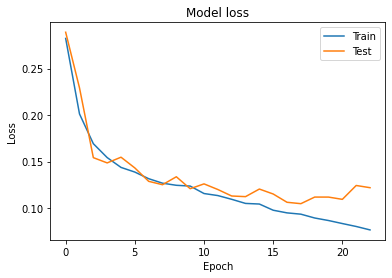

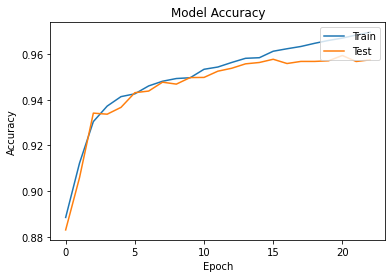

In [15]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

## Model Evaluation

In [45]:
#Load the Model
from keras.models import load_model
model = load_model("transfer_model_20000n.tf", custom_objects={'f1_m': f1_m, 'precision_m':precision_m, 'recall_m':recall_m})
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
preds (Dense)                (None, 17)                34833     
Total params: 14,749,533
Trainable params: 14,749,527
Non-trainable params: 6
_________________________________________________________________


In [46]:
# Evaluating model using test set
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': False}

test_set = train_labels.index[35000:40376]#test size needs to be an exact multiple of the batch size specified by the data generator

test_generator = DataGenerator(test_set, labels_dict, **params)

# make predictions on the testing images
preds = model.predict_generator(test_generator,steps=len(test_set)//params['batch_size'],verbose=1)

21/21 [==============================] - 38s 2s/step


In [47]:
#Get True Labels
truelabels = train_labels.loc[test_set].iloc[:,-17:].values

In [49]:
#Define function to calculate F1 for each class
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve

def class_f1_calc(predictions, truelabels):
    "Returns a dataframe with f1 score values broken down per class for various Thresholds"

    #Initialize a dictionary for accuracy, this dictionary will breakdown accuracy per threshold
    class_f1 = {}
    #Initialize class predictions with all zeros
    preds_threshold = np.zeros(truelabels.shape)

    for threshold in np.arange(0,1.05,0.05):

        #initialize dictionary to hold accuracy per threshold
        class_f1['Threshold: {:.2f}'.format(threshold)] = {}
        i = 0

        for sample in predictions:
            preds_threshold[i] = [1 if class_proba>threshold else 0 for class_proba in sample]
            i += 1

        #flatten array before calling accuracy score to get overall acuracy metric
        class_f1['Threshold: {:.2f}'.format(threshold)]['Overall'] = f1_score(np.ndarray.flatten(truelabels), np.ndarray.flatten(preds_threshold))

        for column_idx in range(len(labels)):
            class_predictions = preds_threshold[:,column_idx]
            true_labels_class = truelabels[:,column_idx]
            class_f1['Threshold: {:.2f}'.format(threshold)][labels[column_idx]] = f1_score(np.ndarray.flatten(true_labels_class), np.ndarray.flatten(class_predictions))

    return (pd.DataFrame.from_dict(class_f1).T)

In [19]:
transfer_model_performance = class_f1_calc(preds, truelabels)
transfer_model_performance

,Overall,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
Threshold: 0.00,0.289372,0.123560,0.964062,0.471642,0.827609,0.302762,0.162051,0.329397,0.204109,0.013671,0.089892,0.306772,0.002230,0.047930,0.017699,0.014404,0.016236,0.004454
Threshold: 0.05,0.777618,0.631687,0.971534,0.781126,0.931348,0.586542,0.439895,0.649308,0.420935,0.113821,0.725926,0.876980,0.166667,0.256311,0.477273,0.192771,0.175000,0.156863
Threshold: 0.10,0.819813,0.681928,0.976349,0.801771,0.940883,0.650737,0.501695,0.690775,0.461935,0.000000,0.757528,0.893699,0.000000,0.284746,0.571429,0.168224,0.232323,0.105263
Threshold: 0.15,0.840956,0.704636,0.978611,0.810870,0.946693,0.684980,0.529126,0.706539,0.489456,0.000000,0.774300,0.900733,0.000000,0.288288,0.629032,0.210526,0.285714,0.000000
Threshold: 0.20,0.855763,0.714491,0.980608,0.819203,0.950190,0.708353,0.545281,0.722222,0.512277,0.000000,0.791171,0.909000,0.000000,0.153846,0.636364,0.172414,0.298246,0.000000
Threshold: 0.25,0.863274,0.688172,0.981471,0.822950,0.952176,0.719878,0.544872,0.724651,0.528231,0.000000,0.799302,0.905000,0.000000,0.150943,0.623853,0.177778,0.232558,0.000000
Threshold: 0.30,0.867269,0.678344,0.982411,0.816290,0.953799,0.721983,0.541618,0.724941,0.535714,0.000000,0.792185,0.906895,0.000000,0.105960,0.640000,0.048780,0.257143,0.000000
Threshold: 0.35,0.870257,0.678808,0.982870,0.806088,0.956555,0.718064,0.505747,0.725037,0.556810,0.000000,0.799277,0.908075,0.000000,0.098592,0.645833,0.000000,0.222222,0.000000
Threshold: 0.40,0.870211,0.652991,0.982762,0.797365,0.957815,0.719812,0.487075,0.712301,0.543689,0.000000,0.801484,0.909184,0.000000,0.086331,0.659574,0.000000,0.200000,0.000000
Threshold: 0.45,0.868799,0.618117,0.982338,0.785300,0.959701,0.713514,0.458874,0.695838,0.536842,0.000000,0.805293,0.908718,0.000000,0.015038,0.681818,0.000000,0.210526,0.000000


In [50]:
#Compute best threshold and best F1 score per class

best_threshold_dict = {} #this dictionary will hold f1 scores per threshold for each label

for col in range(preds.shape[1]):
    
    #get unique values for predictions generated by the model for this class rounded to the second decimal
    threshold_values = np.sort(np.unique(np.around((preds[:,col]),decimals=2)))
    
    #get true labels for this class
    true_labels_class = truelabels[:,col]
    
    best_f1 = 0
 
    for threshold in threshold_values:
        
        #Initialize class predictions with all zeros for each threshold
        preds_threshold = np.zeros(true_labels_class.shape)
        
        #generate predictions for given threshold
        threshold_indices = preds[:,col] > threshold
        preds_threshold[threshold_indices] = 1
        current_f1 = f1_score(true_labels_class, preds_threshold)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    best_threshold_dict[labels[col]] = {'Best_Threshold_Transfer': best_threshold, 'Best_F1_Transfer': best_f1}

transfer_model_results = pd.DataFrame.from_dict(best_threshold_dict).T
transfer_model_results.loc['average'] = transfer_model_results.mean()
transfer_model_results

,Best_Threshold_Transfer,Best_F1_Transfer
haze,0.180000,0.718881
primary,0.380000,0.982964
agriculture,0.230000,0.824270
clear,0.690000,0.963963
water,0.280000,0.726793
habitation,0.240000,0.548691
road,0.280000,0.727104
cultivation,0.350000,0.556810
slash_burn,0.050000,0.113821
cloudy,0.500000,0.811650


In [25]:
#Write Results to File
transfer_model_results.to_csv(r'\Model_Results.csv')

In [51]:
#Get cloud predictions using best threshold 
cloud_labels = ['haze','cloudy','partly_cloudy','clear']

cloud_predictions = np.zeros((preds.shape[0],4))

for label in cloud_labels:
        
    #Get best threshold for each cloud label
    threshold = transfer_model_results.loc[label,'Best_Threshold_Transfer']

    #Use the acquried threshold to make the cloud predictions
    cloud_proba = np.copy(preds[:,labels.index(label)])
    threshold_indices = cloud_proba > threshold
    cloud_predictions[threshold_indices,cloud_labels.index(label)] =  1

In [52]:
cloud_preds_df = pd.DataFrame(cloud_predictions, columns=cloud_labels)
cloud_preds_df['total_predictions'] = cloud_preds_df.sum(axis =1)
cloud_preds_df['total_predictions'].value_counts()

1.0    5240
2.0      97
0.0      39
Name: total_predictions, dtype: int64

There were 97 instances in which the model predicted 2 types of cloud coverage and 39 instances where it predicted none. Let's find out which images caused this to happen and see if we improve our model's predictive power by forcing it to select a single label for cloud coverage.

In [53]:
cloud_preds_df[cloud_preds_df['total_predictions'] != 1].head(10)

,haze,cloudy,partly_cloudy,clear,total_predictions
34,1.0,0.0,0.0,1.0,2.0
50,0.0,0.0,0.0,0.0,0.0
70,1.0,1.0,0.0,0.0,2.0
177,1.0,1.0,0.0,0.0,2.0
178,1.0,0.0,0.0,1.0,2.0
194,1.0,0.0,1.0,0.0,2.0
224,1.0,1.0,0.0,0.0,2.0
246,1.0,0.0,0.0,1.0,2.0
294,0.0,0.0,0.0,0.0,0.0
360,0.0,0.0,0.0,0.0,0.0


In [139]:
#Lets see what some of these labels should have been
print(train_labels.iloc[35034,1])
print(train_labels.iloc[35050,1])
print(train_labels.iloc[35070,1])
print(train_labels.iloc[36225,1])

agriculture clear primary
bare_ground clear road
haze primary
partly_cloudy primary


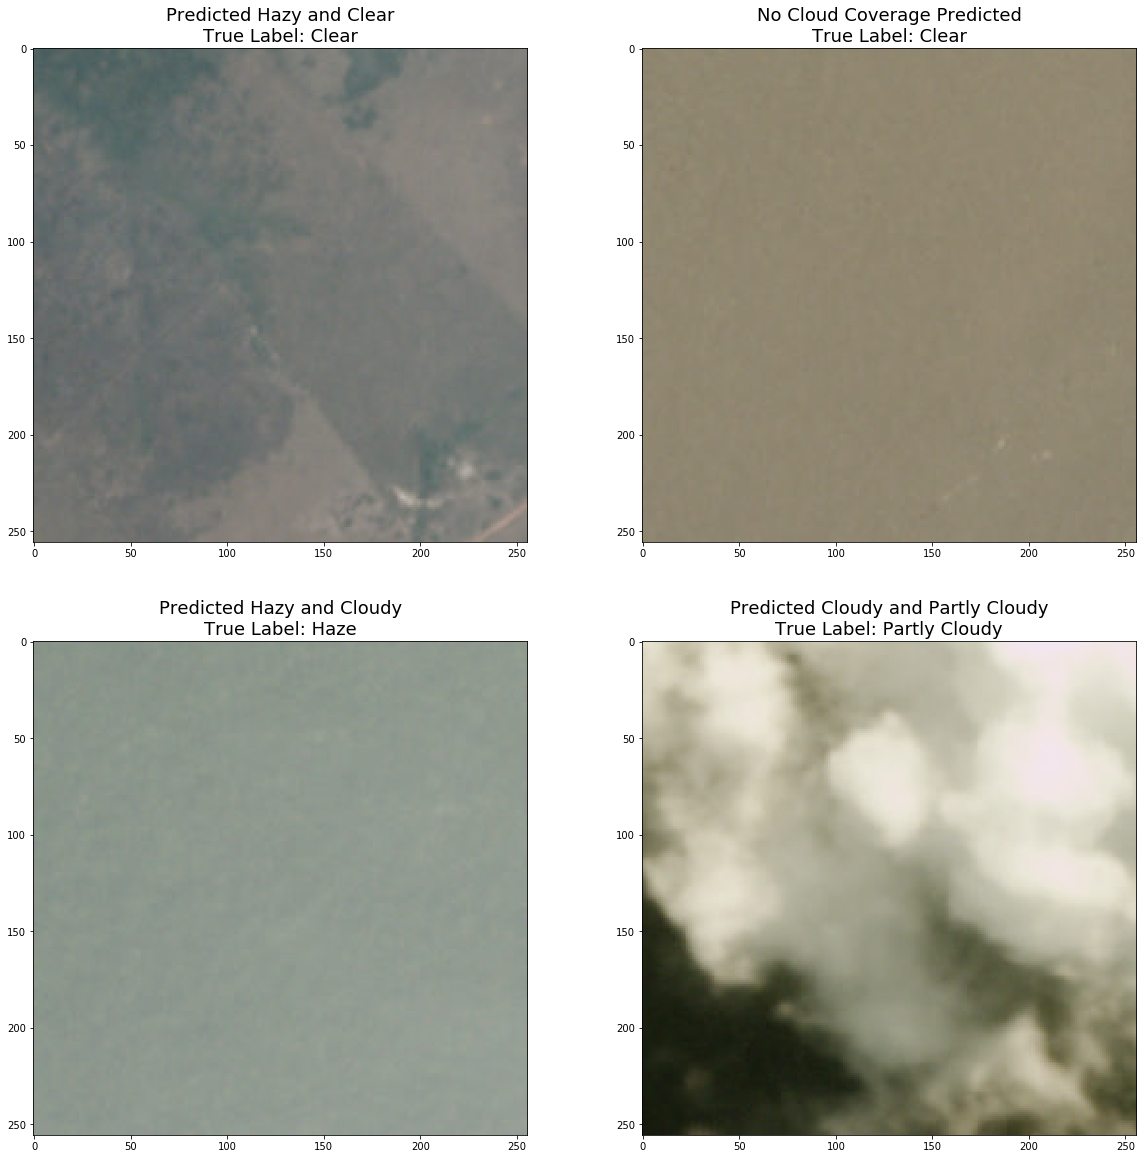

In [14]:
#Let's looks at the images for some of the mistakes the model made
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
ax = axes.ravel()
ax[0].imshow(load_image(train_labels.index[35034]))
ax[0].set_title("Predicted Hazy and Clear\nTrue Label: Clear",fontsize=18)
ax[1].imshow(load_image(train_labels.index[35050]))
ax[1].set_title("No Cloud Coverage Predicted\nTrue Label: Clear",fontsize=18)
ax[2].imshow(load_image(train_labels.index[35070]))
ax[2].set_title("Predicted Hazy and Cloudy\nTrue Label: Haze",fontsize=18)
ax[3].imshow(load_image(train_labels.index[36225]))
ax[3].set_title("Predicted Cloudy and Partly Cloudy\nTrue Label: Partly Cloudy", fontsize=18);

In [91]:
#Let's see if we can make an improvement in our model's predictive power by forcing the model to pick a single cloud cover where it predictied none or 2

cloud_preds_proba = np.copy(preds[:, [labels.index('haze'),labels.index('cloudy'),labels.index('partly_cloudy'),labels.index('clear')]])#extract cloud predictions probabilities

prediction_mistakes = cloud_preds_df['total_predictions'] != 1#indexes where model made a mistake

new_predictions = np.zeros(cloud_preds_proba.shape)

#make new predictions for the mistakes
for num, mistake in enumerate(prediction_mistakes):
    
    if mistake:
        #if a mistake was made we will assign to true label to max predicted value
        index = np.argmax(cloud_preds_proba[num])
        #print(num, cloud_preds_proba[num], index)
        new_predictions[num, index] = 1
    
    else:
         new_predictions[num] = cloud_preds_df.iloc[num,:-1].values

new_preds_df = pd.DataFrame(new_predictions, columns=cloud_labels)
new_preds_df['total_predictions'] = new_preds_df.sum(axis =1)
print(new_preds_df['total_predictions'].value_counts())

1.0    5376
Name: total_predictions, dtype: int64


,haze,cloudy,partly_cloudy,clear,total_predictions
0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...
5371,0.0,0.0,1.0,0.0,1.0
5372,0.0,0.0,0.0,1.0,1.0
5373,1.0,0.0,0.0,0.0,1.0
5374,0.0,0.0,0.0,1.0,1.0


In [124]:
#Now we can assess whether forcing the model to fix a single type of cloud coverage improved overall model performance:
#from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

results_dict = {}

for cloud_type in cloud_labels:
    
    #calculate f1 score, recall, precision using original predictions
    y_pred = cloud_preds_df[cloud_type]
    y_true = truelabels[:,labels.index(cloud_type)]
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    results_dict[('{}').format(cloud_type)] = {'precision':precision,'recall':recall,'F1':f1}
    
    #calculate f1 score, recall, precision using new predictions
    y_pred = new_preds_df[cloud_type]
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    results_dict[('{}_new').format(cloud_type)] = {'precision':precision,'recall':recall,'F1':f1}

#transfer_model_results.loc[cloud_labels,:]


In [127]:
pd.DataFrame.from_dict(results_dict)

,haze,haze_new,cloudy,cloudy_new,partly_cloudy,partly_cloudy_new,clear,clear_new
precision,0.711911,0.768382,0.797710,0.796992,0.908718,0.910309,0.958811,0.953981
recall,0.725989,0.590395,0.826087,0.837945,0.909651,0.906571,0.969170,0.972332
F1,0.718881,0.667732,0.811650,0.816956,0.909184,0.908436,0.963963,0.963069


The only cloud predictions with an improved score were for "cloudy" labels, the improvement was not significant.